# Stochastic SIRD Model using Euler-Maruyama Method

This notebook implements a **Stochastic SIRD (Susceptible-Infected-Recovered-Deceased)** epidemic model using the **Euler-Maruyama method** for solving Stochastic Differential Equations (SDEs).

## Mathematical Formulation

The deterministic SIRD model is extended to a stochastic version by adding noise terms (Brownian motion) to simple rates. The system of SDEs is defined as follows:

$$
\begin{cases}
dS(t) = -\frac{\beta S(t)I(t)}{N} dt - \sigma_1 S(t) dW_1(t) \\
dI(t) = \left( \frac{\beta S(t)I(t)}{N} - \gamma I(t) - \mu I(t) \right) dt + \sigma_2 I(t) dW_2(t) \\
dR(t) = \gamma I(t) dt + \sigma_3 R(t) dW_3(t) \\
dD(t) = \mu I(t) dt + \sigma_4 D(t) dW_4(t)
\end{cases}
$$

Where:
- $S$: Susceptible population
- $I$: Infected population
- $R$: Recovered population
- $D$: Deceased population
- $\beta$: Transmission rate
- $\gamma$: Recovery rate
- $\mu$: Mortality rate
- $\sigma_i$: Volatility parameters (noise intensity)
- $W_i(t)$: Standard Brownian motions
- $N$: Total population ($N \approx S+I+R+D$)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- Configuration ---
class Config:
    # Time settings
    T0 = 0
    T = 365.0        # Time horizon (days)
    N_STEPS = 36500  # Number of steps
    DT = (T - T0) / N_STEPS

    # Disease Parameters (Daily rates)
    # Note: These values were in the original code, verify if they need adjustment for unit consistency
    # lambda_val in original code was likely Beta/N or Beta. Assuming Beta for now.
    BETA = 0.00000000424404 # Transmission parameter (often Beta/N)
    GAMMA = 0.0457600061    # Recovery rate (1/duration)
    MU = 0.0019902810       # Mortality rate

    # Stochastic Volatility
    SIGMA = np.array([0.05, 0.05, 0.05, 0.05]) # [S, I, R, D] noise

    # Initial Conditions
    S0 = 32625831.0
    I0 = 116.0
    R0 = 0.0
    D0 = 1.0

config = Config()

In [2]:
def drift(S, I, R, D, beta, gamma, mu):
    """
    Deterministic drift part of the SDE (The ODE definitions).
    """
    # Assuming 'beta' here is the effective contact rate parameter used in original code (likely beta/N)
    # Note: Standard SIR is beta*S*I/N. If beta is already small, it might be beta*S*I.
    # Using original code's logic: lambda_val * S * I
    infection_rate = beta * S * I
    
    dS = -infection_rate
    dI = infection_rate - gamma * I - mu * I
    dR = gamma * I
    dD = mu * I
    
    return np.array([dS, dI, dR, dD])

def diffusion(S, I, R, D, sigma):
    """
    Stochastic diffusion part (The noise structure).
    Returns a 4x4 diagonal matrix acting on dW vector.
    Using geometric Brownian motion form: sigma * X
    """
    # Diagonal noise structure: each compartment has its own independent proportional noise
    return np.diag([
        sigma[0] * S,
        sigma[1] * I,
        sigma[2] * R,
        sigma[3] * D
    ])

def simulate_sird_stochastic(cfg):
    """
    Simulates SIRD model using Euler-Maruyama method.
    """
    np.random.seed(42) # For reproducibility
    
    time = np.linspace(cfg.T0, cfg.T, cfg.N_STEPS + 1)
    dt = cfg.DT
    
    # Initialize state arrays
    S = np.zeros(cfg.N_STEPS + 1)
    I = np.zeros(cfg.N_STEPS + 1)
    R = np.zeros(cfg.N_STEPS + 1)
    D = np.zeros(cfg.N_STEPS + 1)
    
    S[0], I[0], R[0], D[0] = cfg.S0, cfg.I0, cfg.R0, cfg.D0
    
    # Pre-generate Brownian increments: dW ~ N(0, dt)
    # Shape: (Steps, 4 compartments)
    dW = np.random.normal(0, np.sqrt(dt), size=(cfg.N_STEPS, 4))
    
    for t in range(cfg.N_STEPS):
        # Current state
        s_curr, i_curr, r_curr, d_curr = S[t], I[t], R[t], D[t]
        
        # 1. Deterministic step (Drift)
        f = drift(s_curr, i_curr, r_curr, d_curr, cfg.BETA, cfg.GAMMA, cfg.MU)
        
        # 2. Stochastic step (Diffusion)
        # G is diagonal, so G.dot(dW) is element-wise multiplication for diagonal terms
        # Explicitly: sigma * X * dW
        noise = np.array([
            cfg.SIGMA[0] * s_curr * dW[t, 0],
            cfg.SIGMA[1] * i_curr * dW[t, 1],
            cfg.SIGMA[2] * r_curr * dW[t, 2],
            cfg.SIGMA[3] * d_curr * dW[t, 3]
        ])
        
        # Update
        dX = f * dt + noise
        
        # Enforce non-negativity (simple boundary condition)
        S[t+1] = max(0, s_curr + dX[0])
        I[t+1] = max(0, i_curr + dX[1])
        R[t+1] = max(0, r_curr + dX[2])
        D[t+1] = max(0, d_curr + dX[3])
        
    return time, S, I, R, D

# Run Simulation
time, S, I, R, D = simulate_sird_stochastic(config)

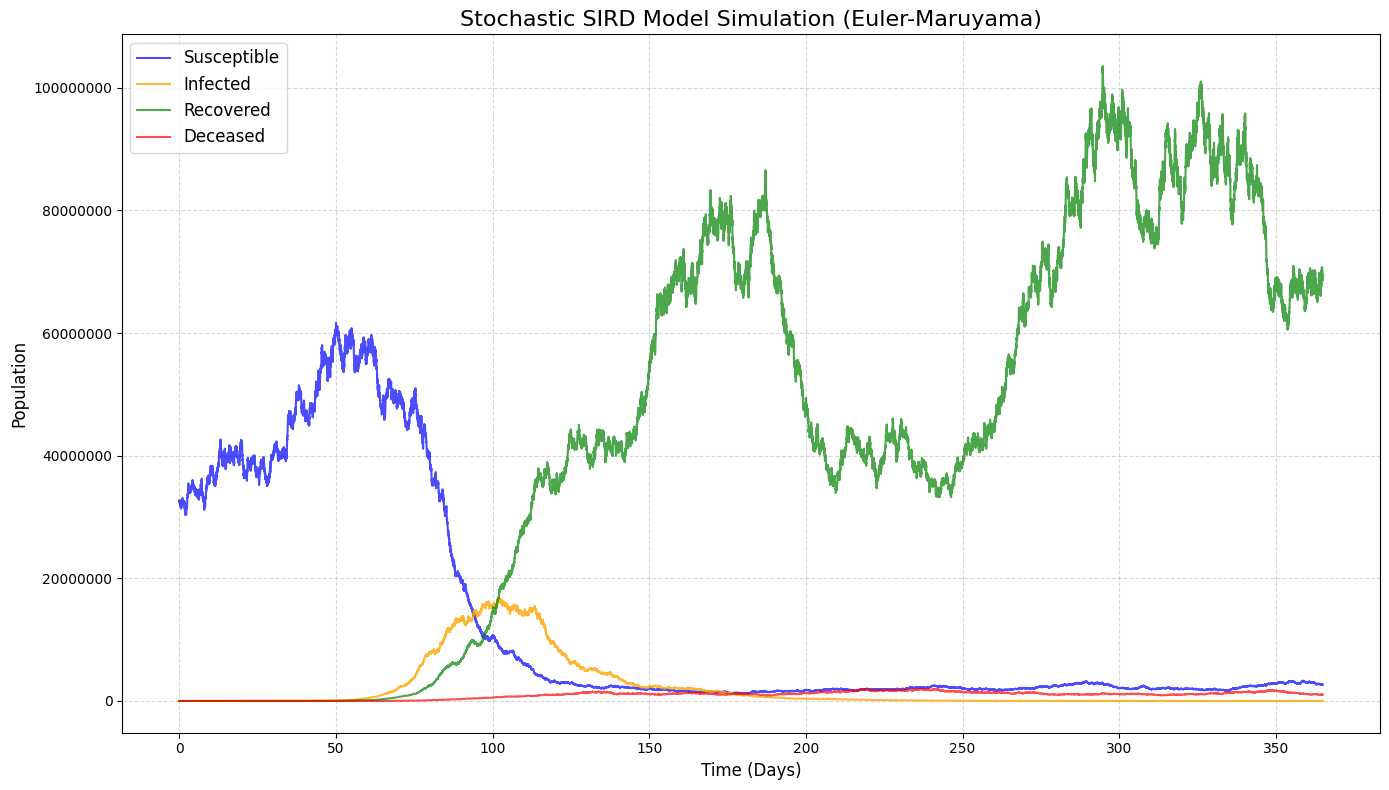

In [3]:
# Plotting Results
plt.figure(figsize=(14, 8))

plt.plot(time, S, label='Susceptible', color='blue', alpha=0.7)
plt.plot(time, I, label='Infected', color='orange', alpha=0.8)
plt.plot(time, R, label='Recovered', color='green', alpha=0.7)
plt.plot(time, D, label='Deceased', color='red', alpha=0.7)

plt.title('Stochastic SIRD Model Simulation (Euler-Maruyama)', fontsize=16)
plt.xlabel('Time (Days)', fontsize=12)
plt.ylabel('Population', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.ticklabel_format(style='plain', axis='y') # Disable scientific notation for population

plt.tight_layout()
plt.show()

## Analysis

The plot allows us to observe the stochastic trajectories of the epidemic. Unlike deterministic models, the paths are "rough" due to the Brownian motion component. This randomness attempts to capture real-world uncertainties in transmission and recovery rates.